Personal identity identification EDA 

In [4]:
from itertools import chain, compress
from collections import Counter, defaultdict
import string 
import re

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import nltk
from nltk.util import ngrams

In [5]:
train = pd.read_json("/kaggle/input/pii-detection-removal-from-educational-data/train.json")
train.head()

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


In [12]:
train.shape

(6807, 6)

In [13]:
train.describe()

,document
count,6807.000000
mean,14739.782283
std,4920.715769
min,7.000000
25%,11061.500000
50%,14818.000000
75%,18974.000000
max,22687.000000


In [16]:
df=train.explode

In [19]:
df

<bound method DataFrame.explode of       document                                          full_text  \
0            7  Design Thinking for innovation reflexion-Avril...   
1           10  Diego Estrada\n\nDesign Thinking Assignment\n\...   
2           16  Reporting process\n\nby Gilberto Gamboa\n\nCha...   
3           20  Design Thinking for Innovation\n\nSindy Samaca...   
4           56  Assignment:  Visualization Reflection  Submitt...   
...        ...                                                ...   
6802     22678  EXAMPLE – JOURNEY MAP\n\nTHE CHALLENGE    My w...   
6803     22679  Why Mind Mapping?\n\nMind maps are graphical r...   
6804     22681  Challenge\n\nSo, a few months back, I had chos...   
6805     22684  Brainstorming\n\nChallenge & Selection\n\nBrai...   
6806     22687  Mind Mapping\n\nChallenge\n\nMy consulting tea...   

                                                 tokens  \
0     [Design, Thinking, for, innovation, reflexion,...   
1     [Diego, Estr

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


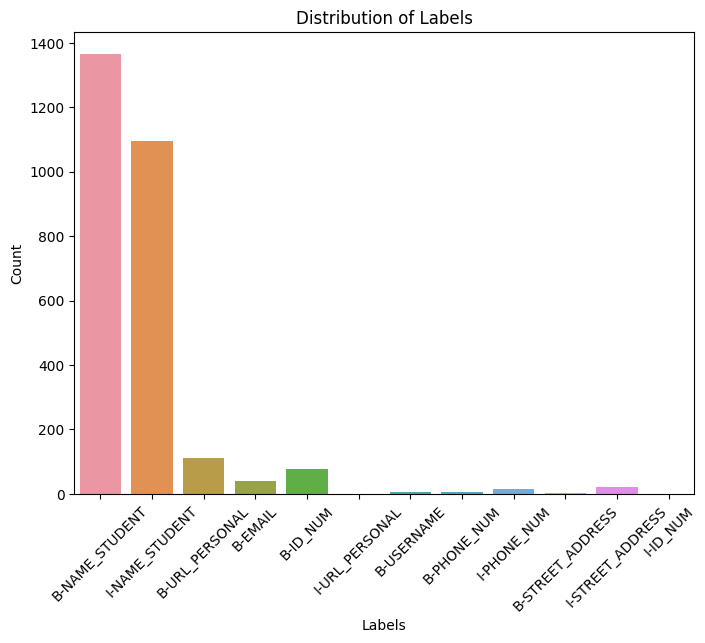

In [11]:
labels_flat = [label for sublist in train['labels'] for label in sublist if label != 'O' ]

# 2. Distribution of Labels
label_counts = Counter(labels_flat)
labels, counts = zip(*label_counts.items())

plt.figure(figsize=(8, 6))
sns.barplot(x=list(labels), y=list(counts))
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [12]:
# 5. Word Frequency Analysis
word_freq = Counter([word for sublist in train['tokens'] for word in sublist])
print(word_freq.most_common(10))


[('the', 236386), (' ', 221248), ('.', 172786), ('to', 161026), (',', 152951), ('and', 136079), ('of', 108775), ('\n\n', 104136), ('a', 92086), ('in', 66727)]


In [18]:
#N-grams Analysis (Example for bigrams)
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(2, 2))
tokens_str = [' '.join(tokens) for tokens in train['tokens']]
tokens_bigrams = cv.fit_transform(tokens_str)
bigram_freq = pd.DataFrame(tokens_bigrams.sum(axis=0), columns=cv.get_feature_names_out()).T
bigram_freq.columns = ['Frequency']
print(bigram_freq.sort_values(by='Frequency', ascending=False).head(10))


                 Frequency
of the               28524
in the               18967
to the               11704
on the                8662
with the              8481
for the               7841
to be                 7483
learning launch       7103
and the               7074
mind mapping          7026


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


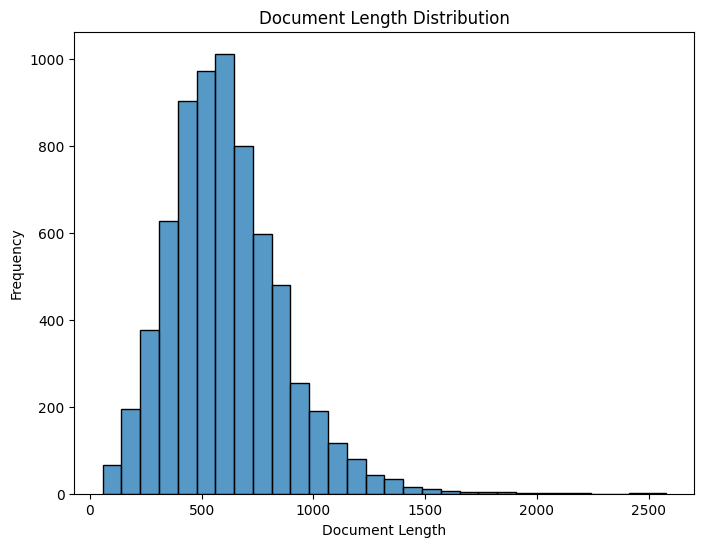

In [13]:
train['doc_length'] = train['full_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 6))
sns.histplot(train['doc_length'], bins=30)
plt.title('Document Length Distribution')
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.show()

Text(0.5, 1.0, '% of examples without a single entity')

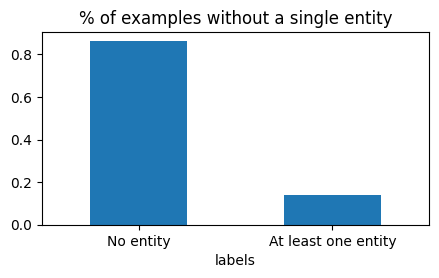

In [7]:

plt.figure(figsize=(5,2.5))
train["labels"].apply(lambda x: "No entity" if set(x)=={'O'} else "At least one entity").value_counts(normalize=True).plot.bar()
plt.xticks(rotation=0)
plt.title('% of examples without a single entity')

In [9]:
# label value counts on the train dataset
labels_chained = chain.from_iterable(train['labels'])
label_counts = Counter(labels_chained)
label_counts


Counter({'O': 4989794,
         'B-NAME_STUDENT': 1365,
         'I-NAME_STUDENT': 1096,
         'B-URL_PERSONAL': 110,
         'B-ID_NUM': 78,
         'B-EMAIL': 39,
         'I-STREET_ADDRESS': 20,
         'I-PHONE_NUM': 15,
         'B-USERNAME': 6,
         'B-PHONE_NUM': 6,
         'B-STREET_ADDRESS': 2,
         'I-URL_PERSONAL': 1,
         'I-ID_NUM': 1})

In [10]:
classes = map(lambda x: x.split("-")[-1], label_counts.keys())
uq_classes = set(classes)
uq_classes



{'EMAIL',
 'ID_NUM',
 'NAME_STUDENT',
 'O',
 'PHONE_NUM',
 'STREET_ADDRESS',
 'URL_PERSONAL',
 'USERNAME'}